>>> jobs
       release  duration  due
Job                          
Job1         6         1    8
Job10        4         7   22
Job11        3         3   11
Job12        3         4    9
Job2         5        10   17
Job3         7         1   16
Job4         6         3   21
Job5         2        10   15
Job6        10         5   17
Job7         5         4   13
Job8         9         6   27
Job9        10         5   21
>>> schedule optimal
       start  finish  past
Job                       
Job15    0.0     3.0   0.0
Job11    3.0     5.0   0.0
Job10    5.0     7.0   0.0
Job1     7.0    10.0   0.0
Job14   10.0    13.0   0.0
Job6    13.0    18.0   1.0
Job8    18.0    21.0   0.0
Job4    21.0    25.0   1.0
Job9    25.0    29.0   3.0
Job3    29.0    34.0  15.0
Job5    34.0    40.0  26.0
Job7    40.0    47.0  27.0
Job12   47.0    54.0  33.0
Job13   54.0    64.0  46.0
Job2    64.0    74.0  44.0


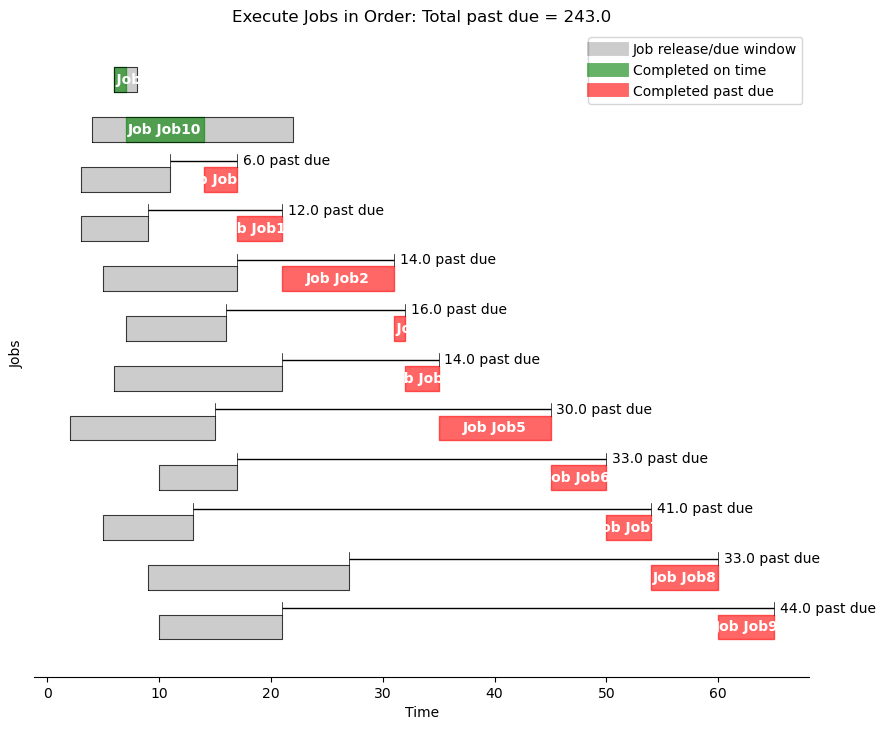

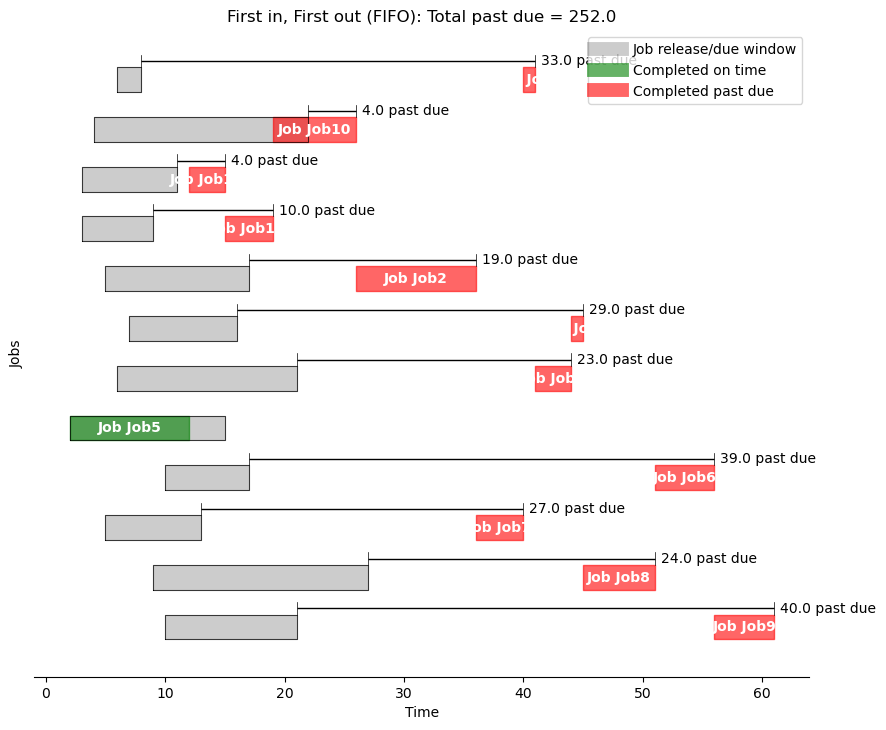

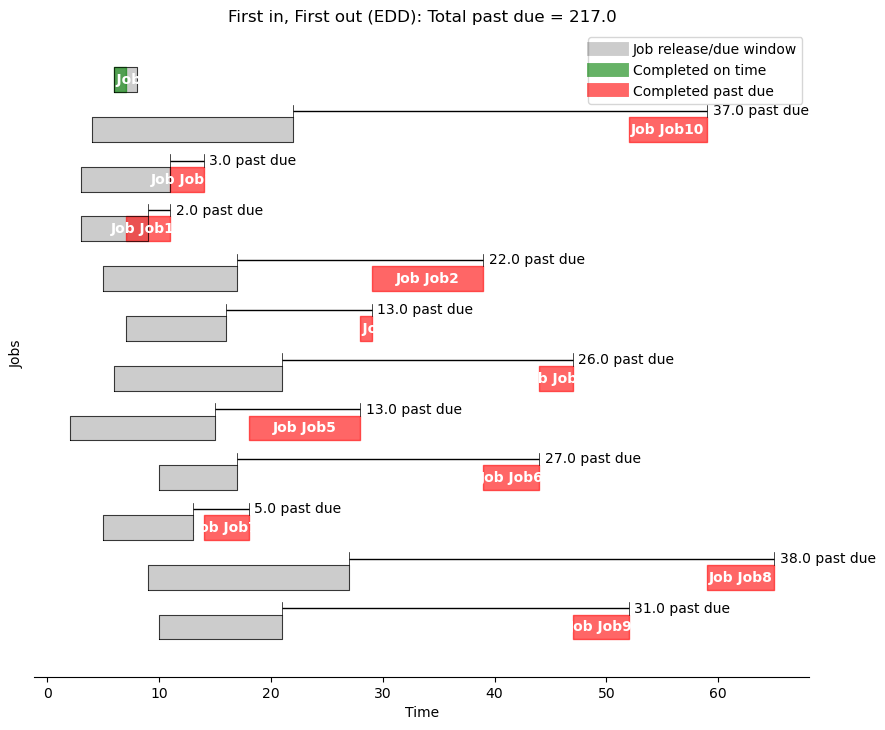

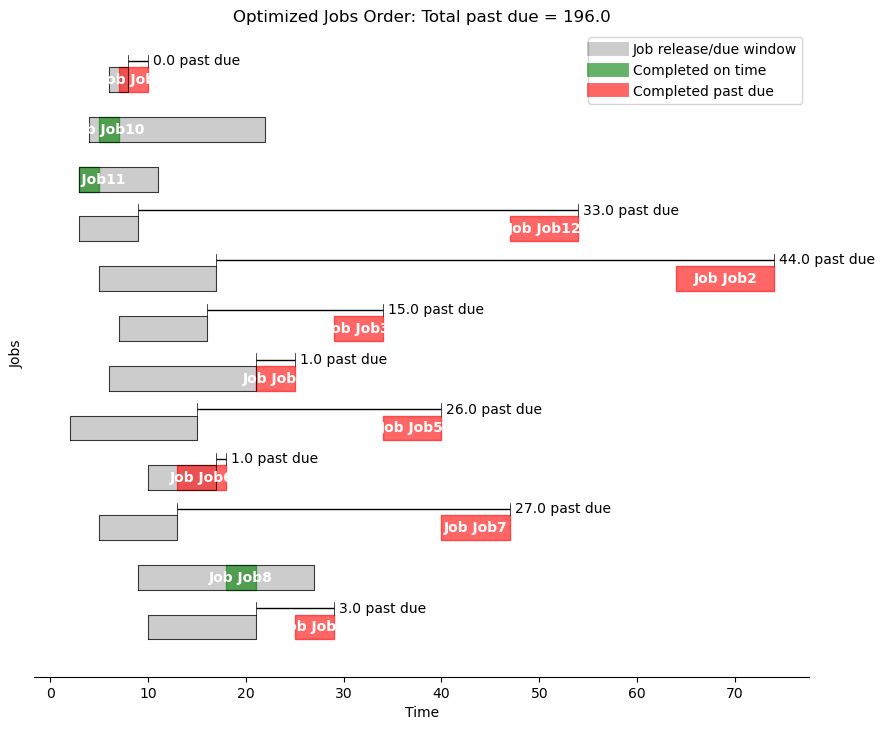

In [1]:


###### Leitura de arquivo #####
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('jobs12.csv')

df.set_index('Job', inplace=True)

jobs = df

print(">>> jobs")
print(jobs)

####################

df = pd.read_csv('resultados_jobs12.csv')
df.set_index('Job', inplace=True)
schedule_optimal = df.rename(columns={'Start': 'start', 'Finish': 'finish', 'Past': 'past'})

# Exibindo o resultado
print(">>> schedule optimal")
print(schedule_optimal)


def schedule_jobs(jobs, seq):
    """
    Schedule a sequence of jobs based on their release times, durations, and due times.

    Args:
        jobs (DataFrame): Job information with columns "release", "duration", and "due".
        seq (DataFrame): A list of job indices representing the sequence in which the jobs will be scheduled.

    Return:
        A DataFrame containing schedule information, including "start", "finish", and "past" due times.
    """
    schedule = pd.DataFrame(index=jobs.index)
    t = 0
    for job in seq:
        t = max(t, jobs.loc[job]["release"])
        schedule.loc[job, "start"] = t
        t += jobs.loc[job, "duration"]
        schedule.loc[job, "finish"] = t
        schedule.loc[job, "past"] = max(0, t - jobs.loc[job, "due"])

    return schedule

schedule = schedule_jobs(jobs, jobs.index)
schedule

def gantt(jobs, schedule, title="Job Schedule"):
    """
    Plot a Gantt chart for a given job schedule.

    Args:
        jobs (DataFrame): Contains job release times and due times.
        schedule (DataFrame): Contains  job start times, finish times, and past due times.
        title (str, optional): Title of the Gantt chart. Defaults to "Job Schedule".
    """
    w = 0.25  # bar width
    fig, ax = plt.subplots(1, 1, figsize=(10, 0.7 * len(jobs.index)))

    for k, job in enumerate(jobs.index):
        r = jobs.loc[job, "release"]
        d = jobs.loc[job, "due"]
        s = schedule.loc[job, "start"]
        f = schedule.loc[job, "finish"]

        # Show job release-due window
        ax.fill_between(
            [r, d], [-k - w, -k - w], [-k + w, -k + w], lw=1, color="k", alpha=0.2
        )
        ax.plot(
            [r, r, d, d, r], [-k - w, -k + w, -k + w, -k - w, -k - w], lw=0.5, color="k"
        )

        # Show job start-finish window
        color = "g" if f <= d else "r"
        ax.fill_between(
            [s, f], [-k - w, -k - w], [-k + w, -k + w], color=color, alpha=0.6
        )
        ax.text(
            (s + f) / 2.0,
            -k,
            "Job " + job,
            color="white",
            weight="bold",
            ha="center",
            va="center",
        )

        # If past due
        if f > d:
            ax.plot([d] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([f] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([d, f], [-k + 1.5 * w] * 2, solid_capstyle="butt", lw=1, color="k")
            ax.text(
                f + 0.5,
                -k + 1.5 * w,
                f"{schedule.loc[job, 'past']} past due",
                va="center",
            )

    total_past_due = schedule["past"].sum()
    ax.set_ylim(-len(jobs.index), 1)
    ax.set_title(f"{title}: Total past due = {total_past_due}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Jobs")
    ax.set_yticks([])  # range(len(jobs.index)), jobs.index)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    custom_lines = [
        Line2D([0], [0], c="k", lw=10, alpha=0.2),
        Line2D([0], [0], c="g", lw=10, alpha=0.6),
        Line2D([0], [0], c="r", lw=10, alpha=0.6),
    ]
    ax.legend(
        custom_lines,
        ["Job release/due window", "Completed on time", "Completed past due"],
    )


gantt(jobs, schedule, "Execute Jobs in Order")
plt.show()

fifo = schedule_jobs(jobs, jobs.sort_values(by="release").index)
gantt(jobs, fifo, "First in, First out (FIFO)")
plt.show()

edd = schedule_jobs(jobs, jobs.sort_values(by="due").index)
gantt(jobs, edd, "First in, First out (EDD)")
plt.show()

gantt(jobs, schedule_optimal, "Optimized Jobs Order")
plt.show()